This notebook will focus on the Exploratory Data Analysis of fault data from a manufacturing process

## Necessary Imports

In [36]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.graphics.gofplots as smg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
from scipy import stats

## Loading the dataset

In [3]:
df = pd.read_csv("/Users/joe/Documents/AiCore/VS Code/DataAnalysisProject/failure_data.csv") 

## Ensuring the Columns are the correct Datatype

Within this there is some initial analysis on the datatypes of the columns in the dataframe. There is a class to convert the datatypes, and a class to give information on the Dataframe. 

In [19]:
class DataTransform:
    def __init__ (self, df):
        self.df = df

    def convert_to_booleen(self):
        bool_cols = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF','RNF'] 
        for col in bool_cols:
            self.df[col] = self.df[col].astype(bool)
        return self.df

transformer = DataTransform(df) 

transformed_df = transformer.convert_to_booleen()

## print(transformed_df.head()) 

class DataFrameInfo:
    def __init__(self, df):
        self.df = df

    def describe_columns(self):
        """Describe all columns to check their data types."""
        return self.df.dtypes

    def extract_statistics(self):
        """Extract median, standard deviation, and mean for numeric columns."""
        stats = self.df.describe().T[['mean', 'std']].copy()
        stats['median'] = self.df.median(numeric_only=True)
        return stats

    def count_distinct(self):
        """Count distinct values in each column."""
        return self.df.nunique()

    def get_shape(self):
        """Return the shape of the DataFrame."""
        return self.df.shape

    def count_nulls(self):
        """Generate a count and percentage count of NULL values in each column."""
        null_counts = self.df.isnull().sum()
        null_percentage = (null_counts / len(self.df)) * 100
        return pd.DataFrame({'null_count': null_counts, 'null_percentage': null_percentage})

    def top_n_categories(self, column, n=5):
        """Show the top N most common values in a categorical column."""
        if column in self.df.select_dtypes(include='object').columns:
            return self.df[column].value_counts().head(n)
        else:
            raise ValueError(f"Column '{column}' is not categorical.")

    def get_summary(self):
        """Print a summary of the DataFrame including basic info."""
        return {
            "Shape": self.get_shape(),
            "Column Data Types": self.describe_columns(),
            "Null Values": self.count_nulls()
        }

# Example usage of the DataFrameInfo class
df_info = DataFrameInfo(transformed_df)

# Print summary
print("Summary of DataFrame:")
print(df_info.get_summary())

# Extract statistics
print("\nStatistics (mean, std, median):")
print(df_info.extract_statistics())

# Count distinct values
print("\nCount of distinct values in each column:")
print(df_info.count_distinct())

# Shape of the DataFrame
print("\nShape of DataFrame:")
print("Rows, Columns:", df_info.get_shape())

# Null counts
print("\nNull value counts and percentages:")
print(df_info.count_nulls())

# Top N categories for 'Type' column

print("\nTop N categories in 'Type':")
print(df_info.top_n_categories('Type'))


Summary of DataFrame:
{'Shape': (10000, 14), 'Column Data Types': UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]            float64
Machine failure               bool
TWF                           bool
HDF                           bool
PWF                           bool
OSF                           bool
RNF                           bool
dtype: object, 'Null Values':                          null_count  null_percentage
UDI                               0              0.0
Product ID                        0              0.0
Type                              0              0.0
Air temperature [K]               0              0.0
Process temperature [K]           0              0.0
Rotational speed [rpm]            0              0.0
Torque [Nm]                       0        

You can see that there is 6 columns which have been converted to the datatype booleen to give True, False values instead of 1,0 values respectively. I did not convert the float datatypes to numerical data as the data was only given to 1 decimal place, therefore using the slower numerical datatype is not necessary. 

## Creating a class to plot the numerical data. 

In [57]:
class Plotter:
    def __init__(self, df):
        self.df = df 
    
    def box_plot_outlier_check(self):
        cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
        for col in cols:
            fig = px.box(self.df, y=col)
            fig.show()     

    def hist_plotter(self):
        cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
        fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(12, 8))  # Create a single subplot for each column

        for i, col in enumerate(cols):
            df[col].hist(bins=40, ax=axes[i])  # Plot histograms on each subplot
            axes[i].set_title(col)  # Set title for each subplot

        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()

    def qq_plotter(self):
        cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
        for col in cols:
            fig, ax = plt.subplots()
            smg.qqplot(self.df[col], line='q', ax=ax)  # Create q-q plot with diagonal line
            ax.set_title(f'Q-Q Plot of {col}')
            ax.set_xlabel('Quantiles of Standardized Data')
            ax.set_ylabel('Quantiles of {col}')
            plt.show()
            
    def d_agostino_k2_test(self):
        cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
        for col in cols:
            stat, p = normaltest(self.df[col], nan_policy='omit')
            print(f"D'Agostino's K-squared Test for {col}")
            print('Statistics=%.3f, p=%.3f' % (stat, p))
            print('----------------------------------')

    def plot_tool_wear_vs_features(self):

        cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]']
        for col in cols:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=col, y='Tool wear [min]', data=self.df)
            plt.xlabel(col)
            plt.ylabel('Tool wear [min]')
            plt.title(f'Tool wear vs. {col}')
            plt.show()

    def z_scores(self):

        cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
        z_scores_df = pd.DataFrame(index=self.df.index) 
        for col in cols:
            z_scores_df[col] = stats.zscore(self.df[col])
        return z_scores_df
    

# Instance of the Plotter class
plotter = Plotter(df)

Working for data imputation:

- Data set of moderate size and columns displaying null percentage rates of <10, therefore imputation is the correct method to use. 

- D’Agostino’s K^2 Test and histogram plots suggest that the data is normally distributed
- Q-q plots suggest normal distribution (at least through the middle of the range)
- Therefore we can infer that the data in normally distributed and the values are missing at random
- Therefore mean value used to impute the missing null values

## Creating a class to impute the null values from the Dataframe based on the workings above

In [42]:
class DataFrameTransform:
    def __init__ (self, df):
        self.df = df
    
    def impute_nulls_mean(self):
        cols = ['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]']
        for col in cols:
            col_mean = self.df[col].mean()
            self.df[col].fillna(col_mean, inplace=True)
        return self.df
    
    def correct_skew_log(self):
        cols = ['Rotational speed [rpm]']
        for col in cols:
            log_column = self.df[col].map(lambda i: np.log(i) if i > 0 else 0)
            t=sns.histplot(log_column,label="Skewness: %.2f"%(log_column.skew()) )
            t.legend()

    def correct_skew_boxcox(self):
        cols = ['Rotational speed [rpm]']
        for col in cols:
            boxcox_column = df[col]
            boxcox_column= stats.boxcox(boxcox_column)
            boxcox_column= pd.Series(boxcox_column[0])
            t=sns.histplot(boxcox_column,label="Skewness: %.2f"%(boxcox_column.skew()) )
            t.legend()


transformer = DataFrameTransform(df)
df_imputed = transformer.impute_nulls_mean()

imputed_df_info = DataFrameInfo(df_imputed)

print("\nNull value counts and percentages after imputation:")
print(imputed_df_info.count_nulls())



Null value counts and percentages after imputation:
                         null_count  null_percentage
UDI                               0              0.0
Product ID                        0              0.0
Type                              0              0.0
Air temperature [K]               0              0.0
Process temperature [K]           0              0.0
Rotational speed [rpm]            0              0.0
Torque [Nm]                       0              0.0
Tool wear [min]                   0              0.0
Machine failure                   0              0.0
TWF                               0              0.0
HDF                               0              0.0
PWF                               0              0.0
OSF                               0              0.0
RNF                               0              0.0


/var/folders/h0/gy3lxpmn2916h35m3d0ww1l80000gn/T/ipykernel_58460/2041786413.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df[col].fillna(col_mean, inplace=True)


From the new Null % counts we can see the data has been successfully imputed!

In [23]:
skew_results = df_imputed[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].skew()

print(skew_results)

Air temperature [K]        0.123842
Process temperature [K]    0.006837
Rotational speed [rpm]     1.993171
Torque [Nm]               -0.009517
Tool wear [min]            0.021715
dtype: float64


As this is a fairly large Dataset (10,000), I will only correct the skew of the columns that are > 1 and < -1. This indicates that Rotational speed is the only column that needs transforming to correct the skew. From looking at the histograms it is clear to see that this column has a clear positive (right) skew. The others do not exhibit such skews and look relatively symmetrical. Air temperature exhibits the next largest skew, but as this dataset is large I do not believe it needs transforming. 

I will start by performing a log transformation to see if it corrects the skew. I will create the method in the DataFrameTransform class as requested. 

The correction after the log transformation:


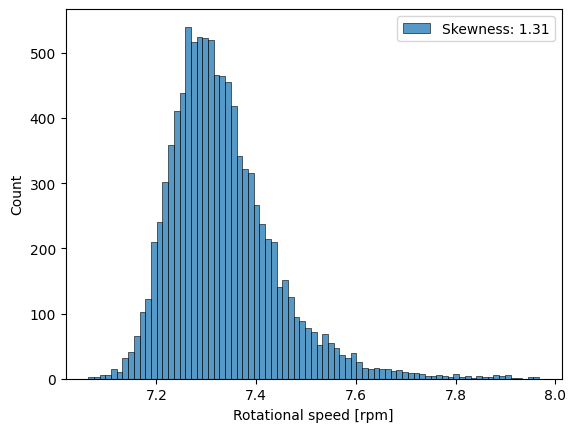

The correction after the Box-Cox transformation:


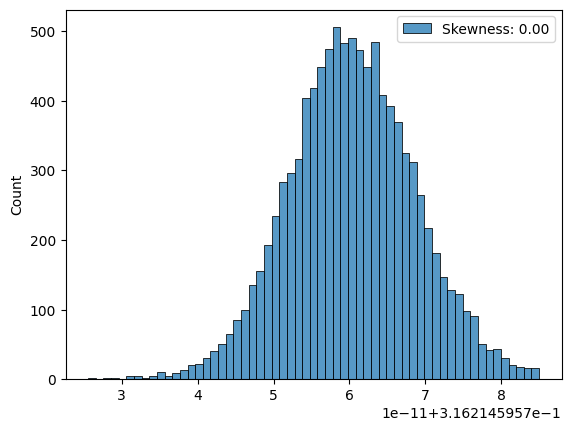

In [49]:
imputed_transformer = DataFrameTransform(df_imputed) # Making a transformer class using the imputed data

imputed_transformer.correct_skew_log() 

print("The correction after the log transformation:")
plt.show() 

imputed_transformer.correct_skew_boxcox() 

print("The correction after the Box-Cox transformation:")
plt.show() 

The above figures show that the a Box-Cox transformation corrects the skewed data to the least amount of skewness, therefore I will use this transformation on the data. 

Saving a separate copy of the dataframe for comparison later:

In [ ]:
df_original = df.copy()

## Dealing with outliers

# Starting with visual methods. 

Using the plotter class methods for creating histograms and boxplots to check for outliers:

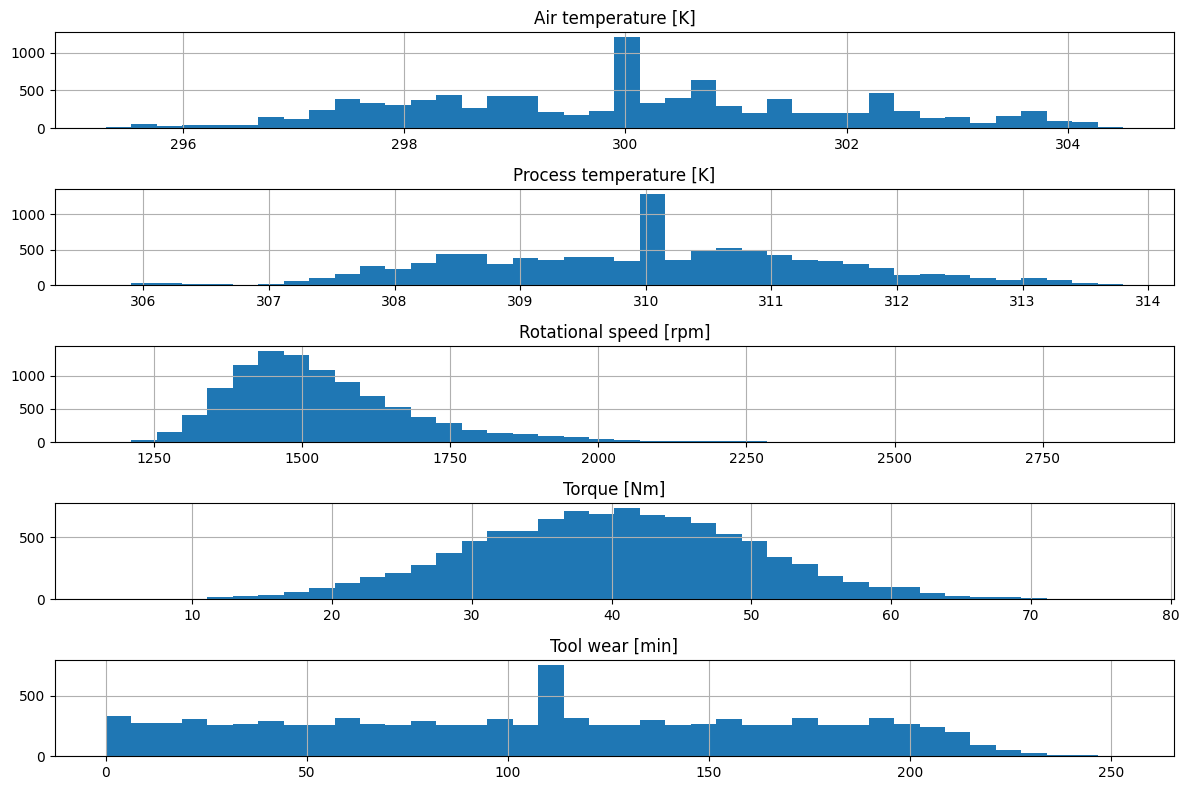

In [52]:
plotter.hist_plotter()

plotter.box_plot_outlier_check()

From boxplots and histograms there doesn't appear to be any obvious outliers in the numerical dataframe columns (Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min]).

Next we look at statistical methods for outlier dection:

Below shows the highest and lowest values of z score for each of the numerical columns. The Z-Score is a statistical measurement that describes a data point's position relative to the mean of a group of values, measured in terms of standard deviations. Data points with a Z-Score having a high absolute value, typically beyond a threshold like 2 or 3, are often considered outliers as they significantly deviate from the average.

In [74]:
z_scores_df = plotter.z_scores()

print('Lowest z score values for Air temperature:')
print(z_scores_df['Air temperature [K]'].sort_values().head())
print('\nHighest z score values for Air temperature:')
print(z_scores_df['Air temperature [K]'].sort_values().tail())

print('\nLowest z score values for Process temperature:')
print(z_scores_df['Process temperature [K]'].sort_values().head())
print('\nHighest z score values for Process temperature:')
print(z_scores_df['Process temperature [K]'].sort_values().tail())

print('\nLowest z score values for Rotational speed:')
print(z_scores_df['Rotational speed [rpm]'].sort_values().head())
print('\nHighest z score values for Rotational speed:')
print(z_scores_df['Rotational speed [rpm]'].sort_values().tail())

print('\nLowest z score values for Torque:')
print(z_scores_df['Torque [Nm]'].sort_values().head())
print('\nHighest z score values for Torque:')
print(z_scores_df['Torque [Nm]'].sort_values().tail())

print('\nLowest z score values for Tool wear:')
print(z_scores_df['Tool wear [min]'].sort_values().head())
print('\nHighest z score values for Tool wear:')
print(z_scores_df['Tool wear [min]'].sort_values().tail())


Lowest z score values for Air temperature:
3975   -2.460790
3031   -2.460790
8425   -2.460790
5077   -2.408528
8873   -2.408528
Name: Air temperature [K], dtype: float64

Highest z score values for Air temperature:
7861    2.295026
5470    2.295026
4919    2.295026
4949    2.295026
2236    2.347288
Name: Air temperature [K], dtype: float64

Lowest z score values for Process temperature:
3975   -3.050594
8425   -3.050594
8873   -2.979840
3031   -2.979840
3124   -2.979840
Name: Process temperature [K], dtype: float64

Highest z score values for Process temperature:
2236    2.609686
5576    2.609686
873     2.609686
3761    2.680440
7084    2.680440
Name: Process temperature [K], dtype: float64

Lowest z score values for Rotational speed:
2913   -2.068196
4048   -1.995682
9874   -1.984526
6979   -1.934324
404    -1.889699
Name: Rotational speed [rpm], dtype: float64

Highest z score values for Rotational speed:
374     7.174581
3610    7.219205
3342    7.375389
4012    7.447904
1517    7.

# Considering the results above.

As can be seen, all columns present z scores in the range of 2 to 3. This indicates deviation from the average. However, these z scores are accompanied by similarly high-absolute-value z scores, and none stand out, even for rotational speed which contains values above 7 (to be expected since we have already seen the data is positively skewed for this column pre-transformation). Therefore I propose that these data are real and useful and should not be removed. If, for example, there was a z score with an absolute value that was signifcantly different to the rest, indicating a true outlier, I would propose removal of this data point. 